In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [14]:
df = pd.read_pickle("../data/df.pickle")

In [15]:
"""Note
データセットの分割
lockdown(2020/4/1~2020/5/31)
2020/6/1~2020/10/31
2020/11/1~2020/11/30
2020/12/1~2020/12/31
2021/1/1~2021/12/31
2022/1/1~2022/12/31
2023/1/1~2023/9/30
"""

# データセットの分割
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")]

In [16]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [17]:
# activity distribution
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [18]:
"""Note 
各データセットについて、それぞれalphaとbetaを推定する
推定したalphaとbetaは、alpha_listとbeta_listに格納する
"""
alpha_list = []
beta_list = []
label = "Year: 2021"
Np = 1652

In [19]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp


In [20]:
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)


In [21]:
# alphaとbetaを推定する
params, _ = optimize.curve_fit(Model3_fixed, edge_2021, node_2021, p0=[0.5, 0.5])
alpha, beta = params[0], params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

In [22]:
kappa_2021 = []
for i in range(len(edge_2021)):
    kappa_2021.append(kappa(edge_2021[i], Np))

In [26]:
kappa_distance_2021 = pd.read_csv("../data/kappa_distance_2021.csv")

In [29]:
# ols
formula = "distance ~ kappa"
res_hatted = smf.ols(formula, data=kappa_distance_2021).fit()
print(res_hatted.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     589.1
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           6.25e-78
Time:                        16:06:07   Log-Likelihood:                 301.94
No. Observations:                 364   AIC:                            -599.9
Df Residuals:                     362   BIC:                            -592.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7916      0.012    154.588      0.0

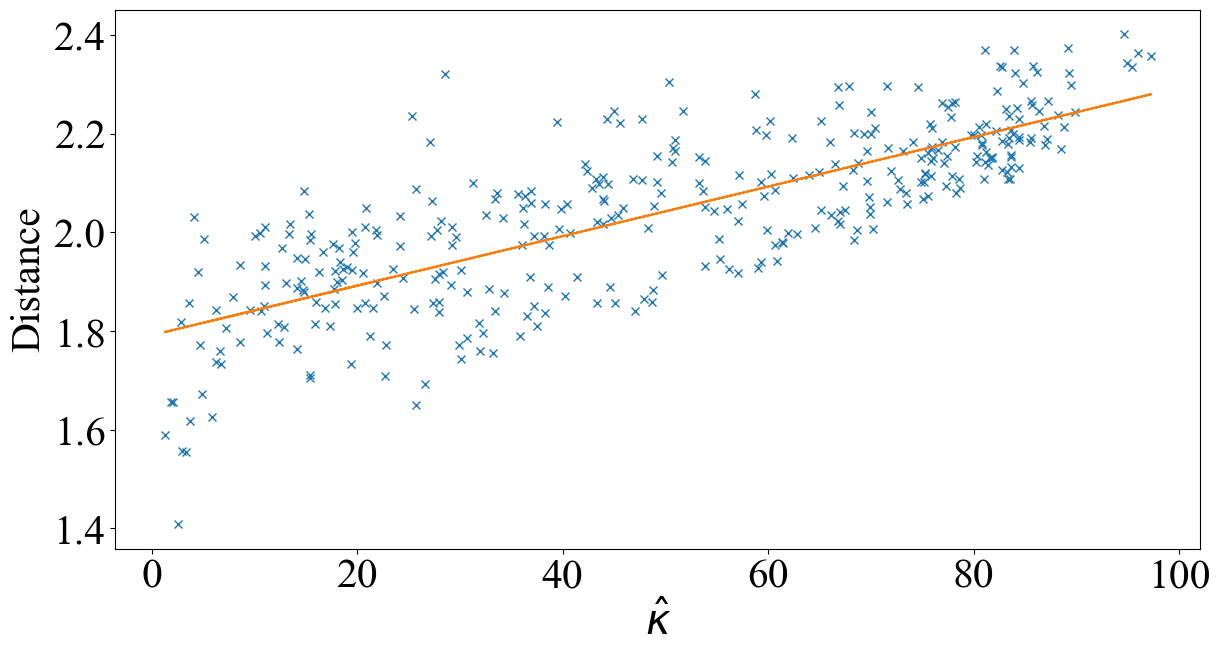

In [34]:
# kappaとdistanceの関係をプロット
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(kappa_distance_2021["kappa"], kappa_distance_2021["distance"],'x', label=label)
plt.plot(kappa_distance_2021["kappa"], res_hatted.fittedvalues, label="OLS")
plt.xlabel(r"$\hat{\kappa}$", fontsize=30)
plt.ylabel("Distance", fontsize=30)
plt.tick_params(labelsize=30)
plt.savefig("../fig/cssj/kappa_distance_2021.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()